# Numerical Optimization and Large Scale Linear Algebra 

In [25]:
from jacobi import point_jacobi, block_jacobi
from gauss_seidel import point_gauss_seidel, block_gauss_seidel
from sor import SOR
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.linalg import norm
import seaborn as sns
sns.set(palette='deep', color_codes=True, font_scale=1.3)
import time

## 1. Table Creation
We create the Discrete Poisson Equation on a 32 x 32 grid

In [2]:
n = 32
T = np.zeros((n**2, n**2))

diag_ind = np.diag_indices(n**2)
T[diag_ind] = 4
lo_diag_ind_rows, lo_diag_ind_columns = np.diag_indices(n**2 - 1)
lo_diag_ind_rows = lo_diag_ind_rows + 1
T[lo_diag_ind_rows, lo_diag_ind_columns] = -1

up_diag_ind_rows, up_diag_ind_columns = np.diag_indices(n**2 - 1)
up_diag_ind_columns = up_diag_ind_columns + 1
T[up_diag_ind_rows, up_diag_ind_columns] = -1

#lower identity
for i in range(n, n**2, n):
    T[i:i+n, i-n:i] = -1 * np.identity(n)

#upper identity
for i in range(0, n**2 -n, n):
    T[i:i+n, i+n:i+2*n] = -1 * np.identity(n)

b = np.ones(n ** 2)

## 2. Point Jacobi

For the point jacobi method the iterative scheme is quite trivial and can be implemented in parallel with vectorized operations.
We know that $$Dx^{k+1} = (L+U)x^k + b$$
Since D is a diagonal table, we do not need to find the inverse using elmination. In fact, we calculate $$D^{-1} = [\frac{1}{a_{11}}, \frac{1}{a_{22}},..., \frac{1}{a_{nn}}]$$

where $D^{-1}$ is a vector containing the inverse of the diagonal elements of A. Then, we can rewrite the previous expressions as:
$$x^{k+1} = ((L+U)x^k + b) * {D}^{-1}$$
where $D^{-1} = [\frac{1}{a_{11}}, \frac{1}{a_{22}},..., \frac{1}{a_{nn}}]$ and $((L+U)x^k + b) * {D}^{-1} $ performs an element wise multiplication.

In [6]:
point_jacobi(A=T, b=b, precision=1e-4, max_iter=2000, verbose=True, return_iter=False)

# found solutions [2.02652054 3.55317429 4.77782091 ... 4.77782041 3.55317424 2.02652036]
# in 845 iterations in 0.8073599338531494 seconds
# absolute relative error 9.959885568644902e-05


array([2.02652054, 3.55317429, 4.77782091, ..., 4.77782041, 3.55317424,
       2.02652036])

## 3. Parallel Block Jacobi

The block jacobi method involves the split of the table A in blocks and then the solution of small systems, 2x2, 4x4, 8x8. We have the epxression:
$$D_{block}x^{k+1}_{block} = (L_{block}+U_{block})x^k_{block} + b_{block}$$

In more detail, with a block size 2x2 it is written as:

$$
  \begin{bmatrix}
    a_{11} & a_{12} & & & & & \\
    a_{21} & a_{22} & & & & &\\
    & & a_{33} & a_{34} & & &\\
    & & a_{43} & a_{44} & & &\\
    & & & & \ddots& &\\
    & & & & & &\\
    & & & & &  a_{n-1, n-1} &  a_{n-1, n}\\
    & & & & & a_{n, n-1} & a_{n, n}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_1^{k+1}\\ 
      x_2^{k+1}\\
      x_3^{k+1}\\
      x_4^{k+1}\\
      \\
      \vdots\\
      x_{n_1}^{k+1}\\
      x_n^{k+1}\\
      \end{bmatrix}
  = 
  \begin{bmatrix}
    0& 0& -a_{13} & -a_{14} & \ldots & -a_{1n-1}&-a_{1n} \\
    0& 0& -a_{23} &-a_{24} & \ldots & -a_{2n-1}&-a_{2n} \\
    -a_{31}& -a_{32}& & & & &\\
    -a_{41}&-a_{42} & & & & &\\
    \vdots& \vdots& & & \ddots& &\\
    \vdots& \vdots& & &\ddots& & &\\
    -a_{n-1,1}& -a_{n-1,2}& & & & 0&0\\
    -a_{n1}&-a_{n,2} & & & & 0&0\\
  \end{bmatrix} 
    \begin{bmatrix}
      x_1^{k}\\ 
      x_2^{k}\\
      x_3^{k}\\
      x_4^{k}\\
      \\
      \vdots\\
      x_{n_1}^{k}\\
      x_n^{k}\\
      \end{bmatrix}
    + 
    \begin{bmatrix}
      b_1^{k}\\ 
      b_2^{k}\\
      b_3^{k}\\
      b_4^{k}\\
      \\
      \vdots\\
      b_{n_1}^{k}\\
      b_n^{k}\\
      \end{bmatrix}
  $$

Executing the operations on the right hand side of the system we have:

$$
  \begin{bmatrix}
    a_{11} & a_{12} & & & & & \\
    a_{21} & a_{22} & & & & &\\
    & & a_{33} & a_{34} & & &\\
    & & a_{43} & a_{44} & & &\\
    & & & & \ddots& &\\
    & & & & & &\\
    & & & & &  a_{n-1, n-1} &  a_{n-1, n}\\
    & & & & & a_{n, n-1} & a_{n, n}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_1^{k+1}\\ 
      x_2^{k+1}\\
      x_3^{k+1}\\
      x_4^{k+1}\\
      \\
      \vdots\\
      x_{n_1}^{k+1}\\
      x_n^{k+1}\\
      \end{bmatrix}
  = 
    \begin{bmatrix}
      \hat{b_1}^{k}\\ 
      \hat{b_2}^{k}\\
      \hat{b_3}^{k}\\
      \hat{b_4}^{k}\\
      \\
      \vdots\\
      \hat{b_{n_1}}^{k}\\
      \hat{b_n^{k}}\\
      \end{bmatrix}
  $$

In our example we have a block size of 2x2 so for each iteration of the jacobi we have to solve the block systems of the form:

$$
  \begin{bmatrix}
    a_{ii} & a_{ii+1}\\
    a_{i+1i} & a_{i+1i+1}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_i^{k+1}\\ 
      x_i+1^{k+1}\\
      \end{bmatrix}
  = 
    \begin{bmatrix}
      \hat{b_i}^{k}\\ 
      \hat{b_{i+1}}^{k}\\
      \end{bmatrix}
  $$
  
In the implementation the block systems are solved in parallel. In order to do this, the matrix has been reshaped to 3-dimensional table `D_blocked`, with dimensions (p, block size, block size) where p = n/block size. Then by acceessing the elements `D_blocked[:, i, i]` we access the pivot elements of all the blocks simultaneously. Since we have the pivot elements, we  proceed in implementing Gauss Jordan elimination is parallel for all the blocks.

In [7]:
block_jacobi(A=T, b=b, block_size=2, precision=1e-4, max_iter=5000, verbose=True, return_iter=False)

# found solutions [2.03065782 3.56135511 4.79001214 ... 4.790012   3.56135533 2.03065793]
# in 679 iterations in 0.5916814804077148 seconds
# absolute relative error 9.962712384460994e-05


## Gauss - Seidel

The Gauss-Seidel method is slightly different from the Jacobi method. Here the system that we are asked to solve is:
$$(D-L)x^{k+1} = Ux^k + b$$

where D-L is a lower triangular table. As a result the system can be solved with forward substitution.

In [9]:
point_gauss_seidel(A=T, b=b, precision=1e-4, max_iter=2000, verbose=True, return_iter=True)

# found solutions [2.03366421 3.5675102  4.79926302 ... 4.80609483 3.57225873 2.03612937]
# in 497 iterations in 2.8112711906433105 seconds
# absolute relative error 9.94696418354892e-05


(array([2.03366421, 3.5675102 , 4.79926302, ..., 4.80609483, 3.57225873,
        2.03612937]),
 497)

## Block Gauss Seidel

This method has similar mentality with the block jacobi method. The matrix `A` and the vectors `x` and `b` are split into blocks. We perform a forward substitution but for each iteration, a smaller system needs to be solved. Here, we cannot avoid the iterative nature of the problem thus we cannot proceed in solving the systems in parallel, since for each block $[x_i, x_{i+1}]$ the previous block of x $[x_{i-1}, x_{i-2}]$ must have been already calculated.

For solving the block systems I used the `solve` method from scipy. An interesting implementation of the gaussian elimination for solving multiple systems in parallel was implemented in the block Jacobi method.

In [11]:
block_gauss_seidel(A=T, b=b, block_size=2, precision=1e-4, max_iter=5000, verbose=True, return_iter=False)

# found solutions [2.03616235 3.57234754 4.80648742 ... 4.81169985 3.5760128  2.03799775]
# in 396 iterations in 13.048820972442627 seconds
# absolute relative error 9.997583057223468e-05


array([2.03616235, 3.57234754, 4.80648742, ..., 4.81169985, 3.5760128 ,
       2.03799775])

## 2. Performance Comparison
In order to compare the performance of the iterative methods, we will perform 3 runs of each and extract an average, in order to have a stable result in case of fluctuations. Additionally, we will execute the functions with the same amount of required precision in order to compare them on an equal basis.

In [14]:
def comparison_diagnostics(solver, name, *args):
    runtime = []
    errors = []
    runs = 3
    for i in range(runs):
        start_time = time.time()
        res = solver(*args)
        end_time = time.time()
        runtime.append(end_time - start_time)
        b_hat = T @ res
        error = norm(b - b_hat) / norm(b)
        errors.append(error)
    df = pd.DataFrame({'runtime':runtime, 'error':error})
    df['solver'] = name
    return df

In [16]:
point_jacobi = comparison_diagnostics(point_jacobi, 'point_jacobi', T, b, 10**(-5), 10**6)

In [15]:
parallel_jacobi_2_block = comparison_diagnostics(block_jacobi, 'block_jacobi_2_block', T, b, 2, 10**(-5), 10**6)
parallel_jacobi_4_block = comparison_diagnostics(block_jacobi, 'block_jacobi_4_block', T, b, 4, 10**(-5), 10**6)
parallel_jacobi_8_block = comparison_diagnostics(block_jacobi, 'block_jacobi_8_block', T, b, 8, 10**(-5), 10**6)

In [17]:
point_gauss_seidel = comparison_diagnostics(point_gauss_seidel, 'point_gauss_seidel', T, b, 10**(-5), 10**6)

In [18]:
gauss_seidel_2_block = comparison_diagnostics(block_gauss_seidel, 'block_gauss_seidel_2_block', T, b, 2, 10**(-5), 10**6)
gauss_seidel_4_block = comparison_diagnostics(block_gauss_seidel, 'block_gauss_seidel_4_block', T, b, 4, 10**(-5), 10**6)
gauss_seidel_8_block = comparison_diagnostics(block_gauss_seidel, 'block_gauss_seidel_8_block', T, b, 8, 10**(-5), 10**6)

In [19]:
comparisons = pd.concat([
    point_jacobi
    ,parallel_jacobi_2_block
    ,parallel_jacobi_4_block
    ,parallel_jacobi_8_block
    ,point_gauss_seidel
    ,gauss_seidel_2_block
    ,gauss_seidel_4_block
    ,gauss_seidel_8_block
])

agg = comparisons.groupby('solver').agg(avg_runtime = ('runtime', np.mean), error = ('error', np.mean)).reset_index()
agg.sort_values(by='avg_runtime', ascending=False, inplace=True)
agg

,solver,avg_runtime,error
0,block_gauss_seidel_2_block,18.355171,0.000728
1,block_gauss_seidel_4_block,8.834194,0.000611
6,point_gauss_seidel,4.436030,0.000923
2,block_gauss_seidel_8_block,4.181077,0.000539
5,block_jacobi_8_block,1.491510,0.001054
3,block_jacobi_2_block,1.179013,0.001379
7,point_jacobi,1.140878,0.001839
4,block_jacobi_4_block,0.958103,0.001166


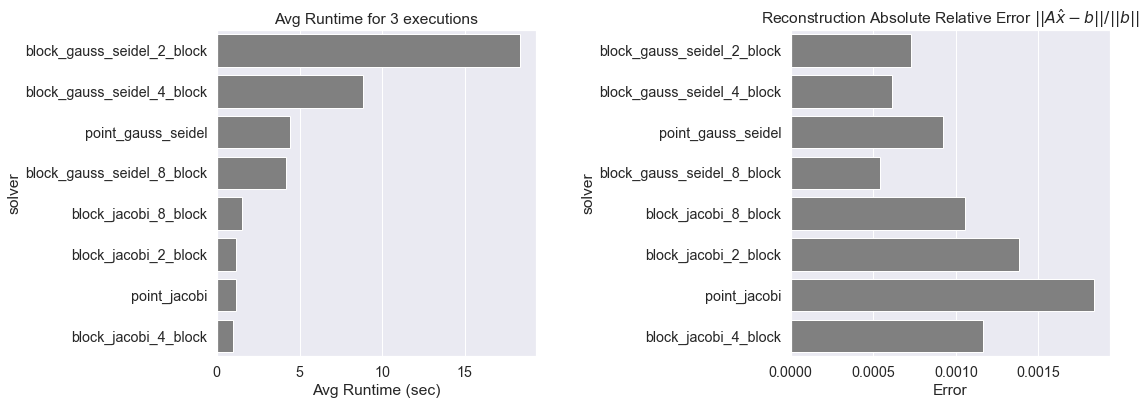

In [21]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.subplots_adjust(wspace=0.8)


sns.barplot(x='avg_runtime', y='solver', data=agg, color='grey', ax=axs[0])
axs[0].set_xlabel('Avg Runtime (sec)')
axs[0].title.set_text('Avg Runtime for 3 executions')

sns.barplot(x='error', y='solver', data=agg, color='grey', ax=axs[1])
axs[1].set_xlabel('Error')
axs[1].title.set_text('Reconstruction Absolute Relative Error $||A\hat{x} - b|| / ||b\||$')
plt.show()

Looking at the runtime results we can observe the following:

* The fastest methods are the point Jacobi as well as the block jacobi with ~1 second of average runtime
* The slowest method is the block gauss seidel where the block size is 2x2
* Jacobi methods seem to have a faster runtime, although the relative erros when recalculating b are larger than those of the Gauss Seidel methods

The Jacobi methods are faster in our case because:

* the point Jacobi uses vectorized operations, avoiding unecessary loops
* the block Jacobi method solves the block systems with Gaussian Elimination `in parallel`, so the for loop has a fixed number of iterations depending on the block size.

## 3. SOR

The Successive overelaxation method is similar to the Gauss Seidel method. In this method, the parameter $\omega$ is introduced such as: $$\frac{1}{\omega}(D - \omega L) x^{k+1} = (\frac{(1-\omega)}{\omega}D + U) x^k + b$$. Similarly to the Gauss Seidel method, the matrix $\frac{1}{\omega}(D - \omega L) $ is lower triangular thus the solution involves a forward substitution for each iteration.

In [27]:
SOR(A=T, b=b, omega=1.8, precision=1e-4, max_iter=5000, verbose=True, return_iter=False)

# found solutions [2.04091022 3.58213361 4.82131825 ... 4.8284834  3.5872406  2.04362538]
# in 72 iterations in 0.6521248817443848 seconds
# absolute relative error 9.106660659458227e-05


array([2.04091022, 3.58213361, 4.82131825, ..., 4.8284834 , 3.5872406 ,
       2.04362538])

Then we need to find the $\omega_{opt}$

In [28]:
from tqdm import tqdm

runtimes = []
errors = []
omegas = np.arange(1,1.96,0.05)
iterations = []
for omega in tqdm(omegas):
    start_time = time.time()
    res, iter_ = SOR(T, b, omega=omega, verbose=False, max_iter=10000, return_iter=True)
    end_time = time.time()
    b_hat = T @ res
    error = norm(b - b_hat) / norm(b)
    errors.append(error)
    runtimes.append(end_time - start_time)
    iterations.append(iter_)

100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


C:\Users\ikats\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


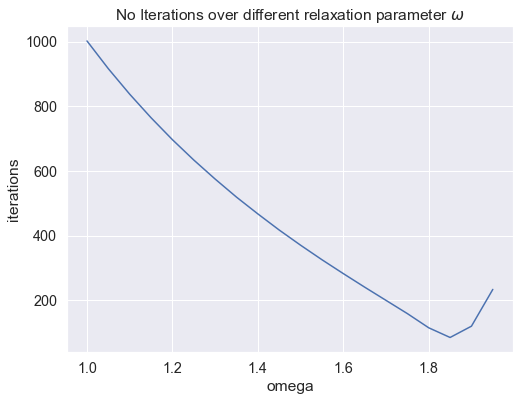

omega optimum between 1.8000000000000007 and 1.9000000000000008 ran over 84.0 iterations


In [29]:
sor_results = pd.DataFrame({
    'omega': omegas
    ,'runtime': runtimes
    ,'error': errors
    ,'iterations': iterations
    
})

fig, axs = plt.subplots(figsize=(8,6))
sns.lineplot(sor_results.omega, sor_results.iterations)
plt.title('No Iterations over different relaxation parameter $\omega$')
plt.show()

opt_index = sor_results.iterations.idxmin()
w_opt_range = sor_results.iloc[opt_index-1: opt_index+2].omega
min_iterations = sor_results.iloc[sor_results.iterations.idxmin()].iterations
print(f'omega optimum between {w_opt_range.min()} and {w_opt_range.max()} ran over {min_iterations} iterations')


From the theorem `3.8` from "Numerical Linear Algebra" (Dougalis, Noutsos, Hatzidimos) we know that

$$\omega_{opt} = \frac{2}{1+\sqrt{1+\beta^2}}$$
where $$\beta = \rho(T_{jacobi})$$

as long as the table is-two cyclic and $\beta = \rho(T_{jacobi}) < 1$ or in other words the Jacobi method converges. We already know that the Jacobi method converges since `T` is a diagonally dominant matrix, meaning that the sum of non diagonal elements is less than the diagonal element. We also know, from the definition, that `T` is a block tridiagonal matrix which by definition is a two-cyclic matrix. Since all the conditions of the theorem are satisfied and assuming that we know analytically the eigenvalues of $T_{jacobi}$ we have:

In [4]:
from scipy.linalg import eigvals

#calculate the T jacobi table
D = T * np.identity(len(T))
D_inv = np.diag(1/np.diag(D))
L = -np.tril(T, -1)
U = -np.triu(T, 1)
T_jacobi = D_inv @ (L+U)

In [5]:
# find the eigenvalues and keep the one with the maximum absolute value
ev  = eigvals(T_jacobi)
sr = max(abs(ev))

In [6]:
omega_opt = 2 / (1+np.sqrt(1-sr**2))
print (f'optimum omega: {omega_opt}')

optimum omega: 1.8263905415884794


Indeed the optimum $\omega$ falls between the range observed when we tried to approach it experimentally.

## 4. $\omega_{opt}$
We know from the theorem of Kahan that in order for the SOR method to converge we need:
$$|\omega-1|<1$$

Also from our experimental results, we observed that values greater than the optimum $\omega$ converged much faster than values less than optimum $\omega$. As a results, based on our findings, it is better to overestimate $\omega$, always in the range defined by Kahan's theorem, otherwise the system will not converge.